In [4]:
# -------------------------------------
# 1. Baca dan parsing file .arff
# -------------------------------------
import arff
import pandas as pd
import numpy as np

# Load file
with open('chronic_kidney_disease_full.arff') as f:
    data = arff.load(f)

# Buat DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1,0,None,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,None,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [5]:
# -------------------------------------
# 2. Simulasi label error (20%)
# -------------------------------------

# Ubah label ke angka manual: ckd = 0, notckd = 1
label_map = {'ckd': 0, 'notckd': 1}
df['class'] = df['class'].map(label_map)

# Simulasikan 20% kesalahan label
n_ubah = int(len(df) * 0.20)
index_to_change = df.sample(n=n_ubah, random_state=42).index
df.loc[index_to_change, 'class'] = df.loc[index_to_change, 'class'].apply(lambda x: 1 if x == 0 else 0)

# Tampilkan distribusi label
print("Jumlah label yang dibalik:", len(index_to_change))
print("Distribusi label setelah dibalik:")
print(df['class'].value_counts())  # 0 = ckd, 1 = notckd

Jumlah label yang dibalik: 80
Distribusi label setelah dibalik:
class
0    226
1    174
Name: count, dtype: int64


In [6]:
# -------------------------------------
# 3. Preprocessing
# -------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Daftar kolom numerik (sesuai dokumentasi CKD)
numerics = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']

# Konversi dan imputasi numerik
for col in numerics:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Ubah ke NaN kalau bukan angka
    df[col] = df[col].fillna(df[col].mean())           # Isi NaN dengan rata-rata

# Kategorikal = semua kolom non-numerik selain class
categoricals = list(set(df.columns) - set(numerics) - {'class'})
from sklearn.preprocessing import LabelEncoder
for col in categoricals:
    df[col] = df[col].fillna(df[col].mode()[0])             # Isi NaN dengan modus
    df[col] = LabelEncoder().fit_transform(df[col])         # Encode ke angka

print("Preprocessing selesai:", df.shape)

Preprocessing selesai: (400, 25)


In [7]:
# -------------------------------------
# 4. Split data & normalisasi
# -------------------------------------
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# -------------------------------------
# 5. SVM Linear
# -------------------------------------
model_linear = SVC(kernel='linear', C=1.0)
model_linear.fit(X_train, y_train)

y_pred_linear = model_linear.predict(X_test)
print("\n📊 Classification Report (SVM Linear):")
print(classification_report(y_test, y_pred_linear, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM Linear):")
print(confusion_matrix(y_test, y_pred_linear))
print(f"✅ Akurasi SVM Linear: {accuracy_score(y_test, y_pred_linear)*100:.2f}%")



📊 Classification Report (SVM Linear):
              precision    recall  f1-score   support

         ckd       0.00      0.00      0.00      28.0
      notckd       0.00      0.00      0.00      52.0

    accuracy                           0.00      80.0
   macro avg       0.00      0.00      0.00      80.0
weighted avg       0.00      0.00      0.00      80.0

🧮 Confusion Matrix (SVM Linear):
[[ 0 28]
 [52  0]]
✅ Akurasi SVM Linear: 0.00%


In [9]:
# -------------------------------------
# 6. SVM RBF
# -------------------------------------
model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
model_rbf.fit(X_train, y_train)

y_pred_rbf = model_rbf.predict(X_test)
print("\n📊 Classification Report (SVM RBF):")
print(classification_report(y_test, y_pred_rbf, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM RBF):")
print(confusion_matrix(y_test, y_pred_rbf))
print(f"🔹 Akurasi SVM RBF: {accuracy_score(y_test, y_pred_rbf)*100:.2f}%")



📊 Classification Report (SVM RBF):
              precision    recall  f1-score   support

         ckd       0.00      0.00      0.00      28.0
      notckd       0.00      0.00      0.00      52.0

    accuracy                           0.00      80.0
   macro avg       0.00      0.00      0.00      80.0
weighted avg       0.00      0.00      0.00      80.0

🧮 Confusion Matrix (SVM RBF):
[[ 0 28]
 [52  0]]
🔹 Akurasi SVM RBF: 0.00%


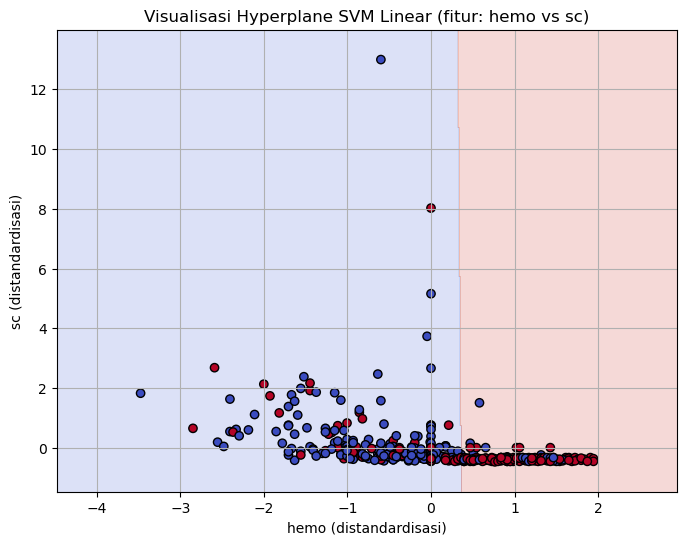

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Ambil 2 fitur numerik yang penting
df_viz = df[['hemo', 'sc', 'class']].dropna()
X = df_viz[['hemo', 'sc']].values
y = df_viz['class'].values

# Normalisasi
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Training SVM Linear
model = SVC(kernel='linear')
model.fit(X, y)

# Buat meshgrid untuk plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Prediksi semua titik dalam meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Visualisasi Hyperplane SVM Linear (fitur: hemo vs sc)")
plt.xlabel("hemo (distandardisasi)")
plt.ylabel("sc (distandardisasi)")
plt.grid(True)
plt.show()


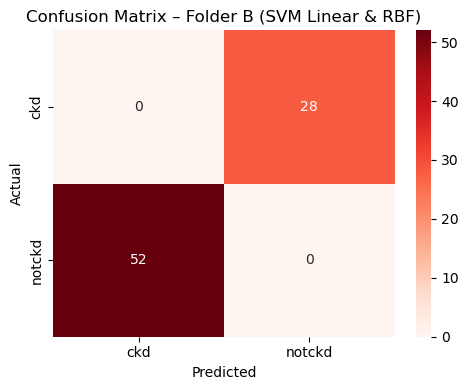

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# setelah prediksi di Folder B (y_test, y_pred_linear)
cm = confusion_matrix(y_test, y_pred_linear)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['ckd', 'notckd'],
            yticklabels=['ckd', 'notckd'])
plt.title('Confusion Matrix – Folder B (SVM Linear & RBF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


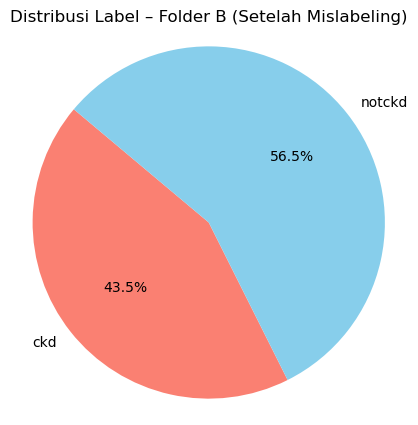

In [12]:
# Folder B – Pie Chart distribusi label setelah mislabel
labels = ['ckd', 'notckd']
counts = df['class'].value_counts(sort=False).values  # setelah mapping

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['salmon', 'skyblue'], startangle=140)
plt.title('Distribusi Label – Folder B (Setelah Mislabeling)')
plt.axis('equal')
plt.show()
